In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix


In [2]:
class EMGClassifier(nn.Module):
    def __init__(self, input_size=44, hidden_sizes=[128,64,32], num_classes=3, dropout_rate=0.1):
        super(EMGClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[1]),
            # nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[2], num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)


In [3]:
df = pd.read_csv('processed_data/train_features.csv')
# feature_set = 'ch'
# feature_set = 'ch'
X = df.filter(regex=r'^(?!.*bp).*ch.*', axis=1)
# X = df.filter(regex=feature_set, axis=1)
y = df['label'].to_numpy()-1

In [4]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X)
import joblib
joblib.dump(scaler, 'temp_scaler.pkl')

['temp_scaler.pkl']

In [7]:

batch_size = 16
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [14]:

model = EMGClassifier()
model.load_state_dict(torch.load('models/MLP.pth'))
cnt = 0
for name, para in model.named_parameters():
    if cnt > 6:
        break
    para.requires_grad = False
    cnt += 1
num_epochs = 100
lr = 0.001
input_size = X_train.shape[1]  # Number of features
num_classes = len(set(y))  # Number of classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [15]:
# Train the model
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    # Forward pass: Compute predicted y by passing x to the model
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if (i+1) % (len(train_dataset) // batch_size) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    scheduler.step()
    losses.append(epoch_loss)


Epoch [1/100], Step [20/21], Loss: 2.2516
Epoch [2/100], Step [20/21], Loss: 2.8813
Epoch [3/100], Step [20/21], Loss: 1.9984
Epoch [4/100], Step [20/21], Loss: 1.9483
Epoch [5/100], Step [20/21], Loss: 1.5227
Epoch [6/100], Step [20/21], Loss: 1.5945
Epoch [7/100], Step [20/21], Loss: 1.1429
Epoch [8/100], Step [20/21], Loss: 1.1364
Epoch [9/100], Step [20/21], Loss: 1.2387
Epoch [10/100], Step [20/21], Loss: 1.0078
Epoch [11/100], Step [20/21], Loss: 0.9946
Epoch [12/100], Step [20/21], Loss: 0.9161
Epoch [13/100], Step [20/21], Loss: 1.1509
Epoch [14/100], Step [20/21], Loss: 1.0066
Epoch [15/100], Step [20/21], Loss: 0.8836
Epoch [16/100], Step [20/21], Loss: 1.2056
Epoch [17/100], Step [20/21], Loss: 1.0337
Epoch [18/100], Step [20/21], Loss: 0.8138
Epoch [19/100], Step [20/21], Loss: 0.9216
Epoch [20/100], Step [20/21], Loss: 1.1216
Epoch [21/100], Step [20/21], Loss: 0.8500
Epoch [22/100], Step [20/21], Loss: 1.1476
Epoch [23/100], Step [20/21], Loss: 1.1372
Epoch [24/100], Step

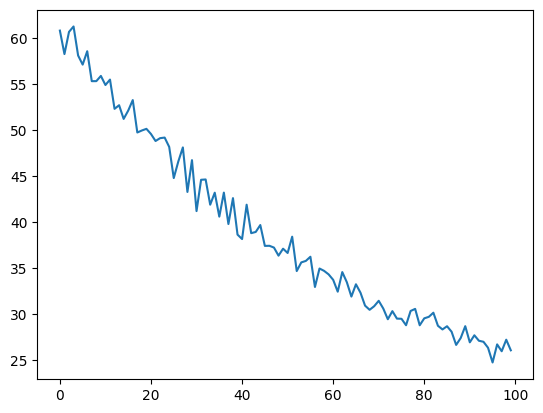

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [11]:
df_test = pd.read_csv('processed_data/test_features.csv')
X_test = df_test.filter(regex=r'^(?!.*bp).*ch.*', axis=1)
y_test = df_test['label'].to_numpy()-1
X_test = scaler.transform(X_test)

In [12]:
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [13]:

model.eval()  # Set the model to evaluation mode
preds = []
actual = []
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    preds.append(predicted)
    actual.append(y_test_tensor)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    

print('Accuracy of the model on the test set: {} %'.format(100 * correct / total))
f1 = f1_score(y_test_tensor, predicted, average=None)
cm = confusion_matrix(y_test_tensor, predicted,labels=[0,1,2])
print(f"f1 score: {f1}")
print(f"confusion matrix:\n {cm}")

Accuracy of the model on the test set: 41.666666666666664 %
f1 score: [0.44827586 0.34615385 0.44827586]
confusion matrix:
 [[13 10  8]
 [ 7  9  5]
 [ 7 12 13]]


In [ ]:
# torch.save(model.state_dict(), 'models/MLP_tuned.pth')